In [1]:
# Disable warnings in Anaconda
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

In [3]:
#replace NaN with median
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

In [5]:
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"
data = pd.read_csv(DATA_PATH + "credit_scoring_sample.csv", sep=";")
data.head()

SeriousDlqin2yrs  age  NumberOfTime30-59DaysPastDueNotWorse    DebtRatio  \
0                 0   64                                     0     0.249908   
1                 0   58                                     0  3870.000000   
2                 0   41                                     0     0.456127   
3                 0   43                                     0     0.000190   
4                 1   49                                     0     0.271820   

   NumberOfTimes90DaysLate  NumberOfTime60-89DaysPastDueNotWorse  \
0                        0                                     0   
1                        0                                     0   
2                        0                                     0   
3                        0                                     0   
4                        0                                     0   

   MonthlyIncome  NumberOfDependents  
0         8158.0                 0.0  
1            NaN                 0.0  
2         6666.0                 0.0  
3        10500.0                 2.0  
4          400.0                 0.0

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45063 entries, 0 to 45062
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      45063 non-null  int64  
 1   age                                   45063 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  45063 non-null  int64  
 3   DebtRatio                             45063 non-null  float64
 4   NumberOfTimes90DaysLate               45063 non-null  int64  
 5   NumberOfTime60-89DaysPastDueNotWorse  45063 non-null  int64  
 6   MonthlyIncome                         36420 non-null  float64
 7   NumberOfDependents                    43946 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 2.8 MB


Distribution of the target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

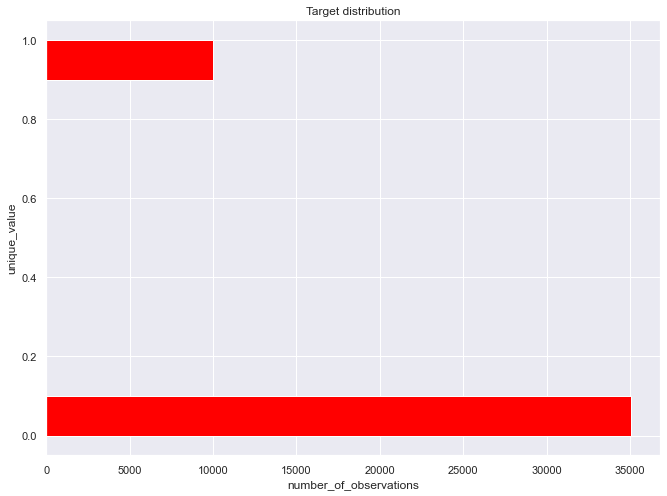

In [8]:
#check the class balance:
ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of the target:")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

In [9]:
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [10]:
table = fill_nan(data)

In [11]:
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

In [13]:
#Bootstrapping
# Save the ages of those who let a delay
churn = data[data["SeriousDlqin2yrs"] == 1]["age"].values

# Set the random seed for reproducibility
np.random.seed(0)

def get_bootstrap_samples(data, n_samples):
    """Generate samples using bootstrapping."""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def stat_intervals(stat, alpha):
    """Make an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
    return boundaries

# Generate bootstrap samples and calculate the mean for each sample
churn_mean_scores = [np.mean(sample) for sample in get_bootstrap_samples(churn, 1000)]

# Print the interval estimate for the sample means
print("Mean interval", stat_intervals(churn_mean_scores, 0.1))


Mean interval [45.71379414 46.12700479]


In [14]:
#Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [15]:
lr = LogisticRegression(random_state=5, class_weight="balanced")

In [16]:
parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

In [17]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [18]:
grid_search = GridSearchCV(lr, parameters, n_jobs=-1, scoring="roc_auc", cv=skf)
grid_search = grid_search.fit(X, y)
grid_search.best_estimator_

LogisticRegression(C=0.001, class_weight='balanced', random_state=5)

In [19]:
grid_search.cv_results_["std_test_score"][1]

0.008137559189742445

In [20]:
#The model is stable if the standard deviation on validation is less than 0.5%. Here is 0.8

grid_search.best_score_

0.8089120626797153

In [22]:
#Feature importance
#Normalize and define
from sklearn.preprocessing import StandardScaler

lr = LogisticRegression(C=0.001, random_state=5, class_weight="balanced")
scal = StandardScaler()
lr.fit(scal.fit_transform(X), y)

pd.DataFrame(
    {"feat": independent_columns_names, "coef": lr.coef_.flatten().tolist()}
).sort_values(by="coef", ascending=False)

feat      coef
1  NumberOfTime30-59DaysPastDueNotWorse  0.723427
3               NumberOfTimes90DaysLate  0.516788
4  NumberOfTime60-89DaysPastDueNotWorse  0.193558
6                    NumberOfDependents  0.101443
2                             DebtRatio -0.024096
5                         MonthlyIncome -0.163146
0                                   age -0.416702

In [24]:
#how much DebtRatio affects the prediction using the softmax function.
lr.coef_[0]

array([-0.41670229,  0.72342698, -0.02409605,  0.51678764,  0.19355764,
       -0.16314632,  0.1014432 ])

In [28]:
print((np.exp(lr.coef_[0]) / np.sum(np.exp(lr.coef_[0])))[2])

0.1142637528306527


In [29]:
lr = LogisticRegression(C=0.001, random_state=5, class_weight="balanced")
lr.fit(X, y)

pd.DataFrame(
    {"feat": independent_columns_names, "coef": lr.coef_.flatten().tolist()}
).sort_values(by="coef", ascending=False)

feat      coef
1  NumberOfTime30-59DaysPastDueNotWorse  0.446831
3               NumberOfTimes90DaysLate  0.390379
4  NumberOfTime60-89DaysPastDueNotWorse  0.216038
6                    NumberOfDependents  0.191725
2                             DebtRatio -0.000006
5                         MonthlyIncome -0.000011
0                                   age -0.013655

In [30]:
np.exp(lr.coef_[0][0] * 20)
#It is times more likely that the customer won’t repay the debt, where 
#is the feature value increment. That means that if we increased the age by 20 years, the odds that the customer won’t repay would increase by 0.69 times.

0.7610092984522818

In [31]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

In [32]:
rf = RandomForestClassifier(
    n_estimators=100, n_jobs=-1, random_state=42, class_weight="balanced"
)

In [33]:
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

In [34]:
rf_grid_search = GridSearchCV(
    rf, parameters, n_jobs=-1, scoring="roc_auc", cv=skf, verbose=True
)
rf_grid_search = rf_grid_search.fit(X, y)
print(rf_grid_search.best_score_ - grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0.026820670654852385


In [37]:
#the weakest impact in Random Forest model
independent_columns_names[
    np.argmin(rf_grid_search.best_estimator_.feature_importances_)
]

'NumberOfTime30-59DaysPastDueNotWorse'

In [38]:
pd.DataFrame(
    {
        "feat": independent_columns_names,
        "coef": rf_grid_search.best_estimator_.feature_importances_,
    }
).sort_values(by="coef", ascending=False)

feat      coef
1  NumberOfTime30-59DaysPastDueNotWorse  0.301011
3               NumberOfTimes90DaysLate  0.278447
4  NumberOfTime60-89DaysPastDueNotWorse  0.156217
0                                   age  0.115587
2                             DebtRatio  0.076118
5                         MonthlyIncome  0.058277
6                    NumberOfDependents  0.014343

In [39]:
#Bagging
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100],
}

In [40]:
bg = BaggingClassifier(
    LogisticRegression(class_weight="balanced"),
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
)
r_grid_search = RandomizedSearchCV(
    bg,
    parameters,
    n_jobs=-1,
    scoring="roc_auc",
    cv=skf,
    n_iter=20,
    random_state=1,
    verbose=True,
)
r_grid_search = r_grid_search.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [41]:
r_grid_search.best_score_

0.8087951623513827